In [1]:
print("Lung Cancer Classification From Ct scan image (Kaagle Dataset)")

Lung Cancer Classification From Ct scan image (Kaagle Dataset)


In [2]:
import numpy as np
import os
import pandas as pd
import cv2 as cv
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_path ='/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset'

In [4]:
print(os.listdir(train_path))

['Normal cases', 'Bengin cases', 'Malignant cases']


In [5]:
data_label={
    'Normal cases':0,
    'Bengin cases' :1,
    'Malignant cases' :2,
    
}
print(data_label['Normal cases'])

0


In [6]:
X =[]
Y =[]
for img_class in os.listdir(train_path):
    for img in os.listdir(os.path.join(train_path, img_class)):
        img_path = os.path.join(train_path, img_class, img)
        img_arr = cv.imread(img_path)
        resize_img = cv.resize(img_arr,(224,224))
        X.append(resize_img)
        Y.append(data_label[img_class])

In [7]:
X[0].shape

(224, 224, 3)

In [8]:
# X_val =[]
# Y_val =[]
# val_path = '/kaggle/input/chest-ctscan-images/Data/valid'
# for img_class in os.listdir(val_path):
#     for img in os.listdir(os.path.join(val_path, img_class)):
#         img_path = os.path.join(val_path, img_class, img)
#         img_arr = cv.imread(img_path)
#         resize_img = cv.resize(img_arr,(224,224))
#         X_val.append(resize_img)
#         Y_val.append(data_label[img_class])

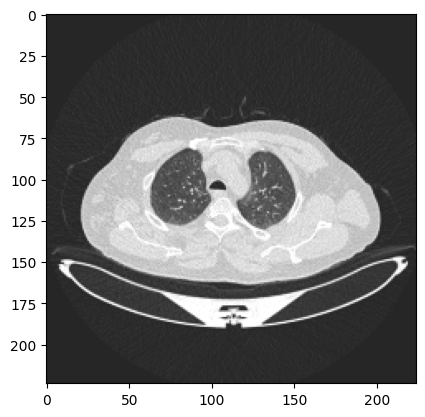

In [9]:
import matplotlib.pylab as plt
plt.imshow(X[10], cmap='gray')



In [10]:
# X[10]
# np.max(x)

In [11]:
# import cv2
# window_name = 'Image'
# cv2.imshow(window_name, X[10])

In [12]:
X = [value / 255.0 for value in X]
# X_val = [value / 255.0 for value in X_val]

x_train = np.array(X)
y_train = np.array(Y)

# x_val = np.array(X_val)
# y_val = np.array(Y_val)

In [13]:
np.max(x_train)

1.0

In [14]:
print(x_train.shape)
print(y_train.shape)

# print(x_val.shape)
# print(y_val.shape)

(1097, 224, 224, 3)
(1097,)


In [15]:
np.max(x_train)

1.0

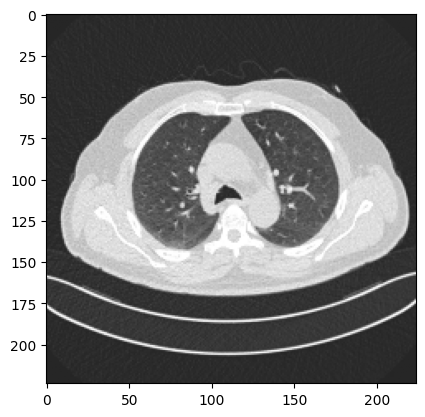

In [16]:
import matplotlib.pylab as plt
plt.imshow(X[4], cmap='gray')

In [17]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x_train,y_train, shuffle=True, test_size=0.1)

In [18]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(987, 224, 224, 3)
(987,)
(110, 224, 224, 3)
(110,)


In [19]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D,MaxPool2D, Dense, Conv2D, Normalization, BatchNormalization, Flatten, Dropout, Input, Activation, Concatenate, Multiply, Add
from tensorflow.keras.models import Model
from keras.layers.serialization import activation

In [20]:
from keras.applications.vgg16 import VGG16
w ='/kaggle/input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_vgg16 = VGG16(
    include_top=False,
    weights= w,
    input_shape=(224,224,3),
    classifier_activation="relu",
)
for layer in base_vgg16.layers:
  layer.trainable = False

In [21]:
import tensorflow as tf
from tensorflow.keras import layers

def cbam_block(input_feature, ratio=8):
    # Channel Attention (CA) submodule
    x = input_feature
    batch, _, _, channel = x.shape
    
    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats_ca = x1 + x2
    feats_ca = Activation("sigmoid")(feats_ca)
    feats_ca = Multiply()([x, feats_ca])

    # Spatial Attention (SA) submodule
    ## Average Pooling
    y1 = tf.reduce_mean(feats_ca, axis=-1)
    y1 = tf.expand_dims(y1, axis=-1)

    ## Max Pooling
    y2 = tf.reduce_max(feats_ca, axis=-1)
    y2 = tf.expand_dims(y2, axis=-1)

    ## Concatenat both the features
    feats_sa = Concatenate()([y1, y2])
    ## Conv layer
    feats_sa = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats_sa)
    feats_sa = Multiply()([x, feats_sa])

    # Combine CA and SA
    cbam_feature = layers.Add()([feats_ca, feats_sa])

    return cbam_feature

In [22]:
x = base_vgg16.output
# x = Conv2D(256, (3,3), padding="same", activation="relu") (x)
# x = Conv2D(128, (3,3), padding="same", activation="relu") (x)
# x = GlobalMaxPooling2D() (x)
x = Flatten() (x)
x = Dense(526, activation= "relu") (x)
x = Dropout(rate=0.2)(x)

x = Dense(128, activation="sigmoid") (x)
x = Dense(64, activation="sigmoid") (x)
output = Dense(3, activation = 'softmax') (x)
vgg_16_model = Model(base_vgg16.input, output)

vgg_16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [23]:
vgg_16_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [24]:
print("x shape:", x_train.shape)
print("y shape:", y_train.shape)
# print("x_val shape:", x_val.shape)
# print("y_val shape:", y_val.shape)

x shape: (987, 224, 224, 3)
y shape: (987,)


In [25]:
vgg16_history = vgg_16_model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
25/25 [==============================] - 22s 347ms/step - loss: 0.9066 - accuracy: 0.6274 - val_loss: 0.6848 - val_accuracy: 0.8333
Epoch 2/20
25/25 [==============================] - 4s 153ms/step - loss: 0.6381 - accuracy: 0.8061 - val_loss: 0.3744 - val_accuracy: 0.9091
Epoch 3/20
25/25 [==============================] - 4s 153ms/step - loss: 0.4064 - accuracy: 0.8542 - val_loss: 0.3230 - val_accuracy: 0.8939
Epoch 4/20
25/25 [==============================] - 4s 154ms/step - loss: 0.3212 - accuracy: 0.8657 - val_loss: 0.3051 - val_accuracy: 0.8788
Epoch 5/20
25/25 [==============================] - 4s 154ms/step - loss: 0.2754 - accuracy: 0.8859 - val_loss: 0.1865 - val_accuracy: 0.9394
Epoch 6/20
25/25 [==============================] - 4s 154ms/step - loss: 0.2171 - accuracy: 0.9100 - val_loss: 0.1478 - val_accuracy: 0.9747
Epoch 7/20
25/25 [==============================] - 4s 155ms/step - loss: 0.1661 - accuracy: 0.9506 - val_loss: 0.0953 - val_accuracy: 0.9747
Epoch

In [26]:
x = cbam_block(base_vgg16.layers[-1].output)
x = Flatten() (x)
x = Dense(526, activation= "relu") (x)
x = Dropout(rate=0.2)(x)

x = Dense(128, activation="sigmoid") (x)
x = Dense(64, activation="sigmoid") (x)
output = Dense(3,activation = 'softmax') (x)
vgg_16_cbam_model = Model(base_vgg16.input, output)

vgg_16_cbam_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [27]:
vgg_16_cbam_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [28]:
vgg16_cbam_history = vgg_16_cbam_model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
25/25 [==============================] - 9s 194ms/step - loss: 0.7634 - accuracy: 0.6920 - val_loss: 0.4026 - val_accuracy: 0.8586
Epoch 2/20
25/25 [==============================] - 4s 167ms/step - loss: 0.3755 - accuracy: 0.8568 - val_loss: 0.2867 - val_accuracy: 0.9040
Epoch 3/20
25/25 [==============================] - 4s 168ms/step - loss: 0.2454 - accuracy: 0.8973 - val_loss: 0.1897 - val_accuracy: 0.9192
Epoch 4/20
25/25 [==============================] - 4s 169ms/step - loss: 0.1395 - accuracy: 0.9607 - val_loss: 0.0735 - val_accuracy: 0.9899
Epoch 5/20
25/25 [==============================] - 4s 170ms/step - loss: 0.0684 - accuracy: 0.9899 - val_loss: 0.0477 - val_accuracy: 0.9949
Epoch 6/20
25/25 [==============================] - 4s 169ms/step - loss: 0.0343 - accuracy: 0.9975 - val_loss: 0.0415 - val_accuracy: 0.9949
Epoch 7/20
25/25 [==============================] - 4s 168ms/step - loss: 0.0250 - accuracy: 0.9975 - val_loss: 0.0454 - val_accuracy: 0.9899
Epoch 

In [29]:
test_path = '/kaggle/input/lung-cancer-test/test'
X_test =[]
Y_test =[]
for img_class in os.listdir(test_path):
    for img in os.listdir(os.path.join(test_path, img_class)):
        img_path = os.path.join(test_path, img_class, img)
        img_arr = cv.imread(img_path)
        resize_img = cv.resize(img_arr,(224,224))
        X_test.append(resize_img)
        if img_class == 'BenginCases':
            Y_test.append(1)
        elif img_class == 'normal':
            Y_test.append(0)
        else:
            Y_test.append(2)
            
X_test = [value / 255.0 for value in X_test]
X_test = np.array(X_test)        
Y_test = np.array(Y_test)

In [30]:
p = []
for data in X_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = vgg_16_cbam_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p.append(pred)
from sklearn.metrics import classification_report
print(classification_report(Y_test, p))

1/1 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       123
           1       1.00      1.00      1.00        11
           2       0.60      1.00      0.75        80

    accuracy                           0.75       214
   macro avg       0.87      0.86      0.83       214
weighted avg       0.85      0.75      0.75       214



In [31]:
p1 = []
for data in x_test:
    input_data = data
    input_data_with_batch = np.expand_dims(input_data, axis=0)
    predictions = vgg_16_cbam_model.predict(input_data_with_batch)
    pred = np.argmax(predictions, axis=-1)
    p1.append(pred)
from sklearn.metrics import classification_report
print(classification_report(y_test, p1))

1/1 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        40
           1       0.83      0.83      0.83        12
           2       0.97      1.00      0.98        58

    accuracy                           0.95       110
   macro avg       0.92      0.92      0.92       110
weighted avg       0.95      0.95      0.95       110



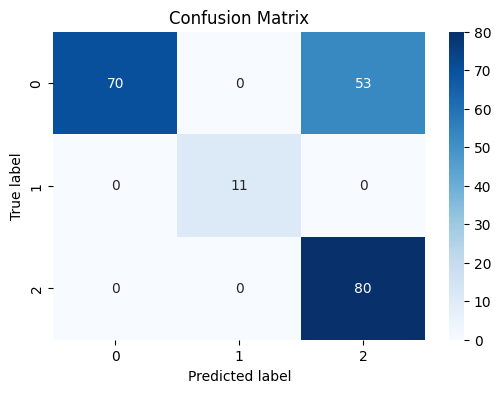

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Calculate confusion matrix
cm = confusion_matrix(Y_test, p)

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['0','1','2'],
            yticklabels=['0','1','2'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

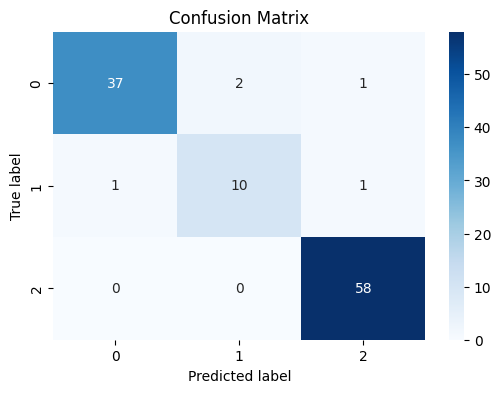

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Calculate confusion matrix
cm = confusion_matrix(y_test, p1)

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['0','1','2'],
            yticklabels=['0','1','2'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

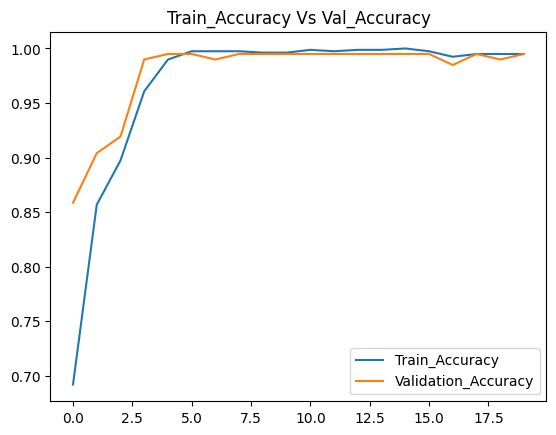

In [34]:
import matplotlib.pyplot as plt
plt.title('Train_Accuracy Vs Val_Accuracy')
plt.plot(vgg16_cbam_history.history['accuracy'], label='Train_Accuracy')
plt.plot(vgg16_cbam_history.history['val_accuracy'], label='Validation_Accuracy')
plt.legend()
plt.show();

In [35]:
vgg_16_cbam_model.save('model_d0.h5')

In [36]:
base_inceptionV3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights= 'imagenet',
    input_shape=(224,224,3),
    classifier_activation="relu",
)
for layer in base_inceptionV3.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [37]:
x = base_inceptionV3.output
x = Flatten() (x)
x = Dense(526, activation= "relu") (x)
x = Dropout(rate=0.2)(x)

x = Dense(128, activation="sigmoid") (x)
x = Dense(64, activation="sigmoid") (x)
output = Dense(3, activation = 'softmax') (x)
inceptionV3_model = Model(base_inceptionV3.input, output)

inceptionV3_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_1[0][0]']               
 alization)                     )                                                           

In [38]:
inceptionV3_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [39]:
inceptionV3_model_history = inceptionV3_model.fit(x_train, y_train, batch_size = 32, epochs=20,validation_split=0.2)

Epoch 1/20
25/25 [==============================] - 14s 260ms/step - loss: 0.9613 - accuracy: 0.5551 - val_loss: 0.7523 - val_accuracy: 0.8939
Epoch 2/20
25/25 [==============================] - 2s 90ms/step - loss: 0.8356 - accuracy: 0.7972 - val_loss: 0.6144 - val_accuracy: 0.9141
Epoch 3/20
25/25 [==============================] - 2s 91ms/step - loss: 0.6707 - accuracy: 0.8365 - val_loss: 0.4765 - val_accuracy: 0.9242
Epoch 4/20
25/25 [==============================] - 2s 91ms/step - loss: 0.5314 - accuracy: 0.8441 - val_loss: 0.3311 - val_accuracy: 0.9293
Epoch 5/20
25/25 [==============================] - 2s 91ms/step - loss: 0.4229 - accuracy: 0.8644 - val_loss: 0.3590 - val_accuracy: 0.8939
Epoch 6/20
25/25 [==============================] - 2s 91ms/step - loss: 0.3723 - accuracy: 0.8644 - val_loss: 0.2635 - val_accuracy: 0.9293
Epoch 7/20
25/25 [==============================] - 2s 91ms/step - loss: 0.3370 - accuracy: 0.8695 - val_loss: 0.2314 - val_accuracy: 0.9293
Epoch 8/20


In [40]:
inceptionV3_model.evaluate(x_test,y_test)

4/4 [==============================] - 2s 502ms/step - loss: 0.2347 - accuracy: 0.9000


[0.23465102910995483, 0.8999999761581421]

In [41]:
inceptionV3_model.evaluate(X_test,Y_test)

7/7 [==============================] - 2s 315ms/step - loss: 1.6173 - accuracy: 0.7336


[1.617292881011963, 0.7336448431015015]

In [42]:
# import tensorflow as tf
# w = '/kaggle/input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
# base_InceptionV3 = tf.keras.applications.InceptionV3(
#     include_top=False,
#     weights= w,
#     input_shape=(224,224,3),
#     classifier_activation="relu",
# )
# for layer in base_InceptionV3.layers:
#     layer.trainable = False

In [43]:
# x = cbam_block(base_InceptionV3.layers[-1].output)
# x = Flatten() (x)
# x = Dense(526, activation= "relu") (x)
# x = Dropout(rate=0.2)(x)

# x = Dense(128, activation="sigmoid") (x)
# x = Dense(64, activation="sigmoid") (x)
# output = Dense(4, activation = 'softmax') (x)
# base_InceptionV3_cbam_model = Model(base_InceptionV3.input, output)

# base_InceptionV3_cbam_model.summary()

In [44]:
# base_InceptionV3_cbam_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [45]:
# InceptionV3_cbam_history = base_InceptionV3_cbam_model.fit(x_train, y_train, batch_size = 32, epochs=30,validation_data = (x_val, y_val))

In [46]:
import tensorflow as tf
base_MobNetV2 = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights= "imagenet",
    input_shape=(224,224,3),
    classifier_activation="relu",
)
for layer in base_MobNetV2.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [47]:
x = base_MobNetV2.output

x = Flatten() (x)
x = Dense(526, activation= "relu") (x)
x = Dropout(rate=0.2)(x)

x = Dense(128, activation="sigmoid") (x)
x = Dense(64, activation="sigmoid") (x)
output = Dense(3, activation = 'softmax') (x)
MobNet2_model = Model(base_MobNetV2.input, output)

MobNet2_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [48]:
MobNet2_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [49]:
MobNet2_model_history = MobNet2_model.fit(x_train, y_train, batch_size = 32, epochs=20,validation_split=0.2)

Epoch 1/20
25/25 [==============================] - 8s 153ms/step - loss: 0.6597 - accuracy: 0.8061 - val_loss: 0.3907 - val_accuracy: 0.8990
Epoch 2/20
25/25 [==============================] - 1s 58ms/step - loss: 0.3987 - accuracy: 0.8593 - val_loss: 0.2809 - val_accuracy: 0.9192
Epoch 3/20
25/25 [==============================] - 1s 57ms/step - loss: 0.3269 - accuracy: 0.8695 - val_loss: 0.2488 - val_accuracy: 0.9192
Epoch 4/20
25/25 [==============================] - 1s 56ms/step - loss: 0.3041 - accuracy: 0.8707 - val_loss: 0.2280 - val_accuracy: 0.9242
Epoch 5/20
25/25 [==============================] - 1s 57ms/step - loss: 0.2811 - accuracy: 0.8771 - val_loss: 0.2135 - val_accuracy: 0.9343
Epoch 6/20
25/25 [==============================] - 1s 56ms/step - loss: 0.2626 - accuracy: 0.8847 - val_loss: 0.1964 - val_accuracy: 0.9293
Epoch 7/20
25/25 [==============================] - 1s 56ms/step - loss: 0.2540 - accuracy: 0.8859 - val_loss: 0.1771 - val_accuracy: 0.9444
Epoch 8/20
2

In [50]:
MobNet2_model.evaluate(X_test,Y_test)

7/7 [==============================] - 1s 126ms/step - loss: 1.6961 - accuracy: 0.7336


[1.6960508823394775, 0.7336448431015015]

In [51]:
MobNet2_model.evaluate(x_test,y_test)

4/4 [==============================] - 1s 192ms/step - loss: 0.1813 - accuracy: 0.9455


[0.18125107884407043, 0.9454545378684998]

In [52]:
base_ResNet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    classifier_activation="relu",
)

94765736/94765736 [==============================] - 1s 0us/step


In [53]:
x = base_ResNet50.output

x = Flatten() (x)
x = Dense(526, activation= "relu") (x)
x = Dropout(rate=0.2)(x)

x = Dense(128, activation="sigmoid") (x)
x = Dense(64, activation="sigmoid") (x)
output = Dense(3, activation = 'softmax') (x)
ResNet50_model = Model(base_ResNet50.input, output)

ResNet50_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [54]:
ResNet50_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [55]:
MobNet2_model_history = ResNet50_model.fit(x_train, y_train, batch_size = 32, epochs=20,validation_split=0.2)

Epoch 1/20
25/25 [==============================] - 55s 522ms/step - loss: 0.5097 - accuracy: 0.8200 - val_loss: 1.4605 - val_accuracy: 0.3838
Epoch 2/20
25/25 [==============================] - 9s 353ms/step - loss: 0.4019 - accuracy: 0.8504 - val_loss: 2.0123 - val_accuracy: 0.3838
Epoch 3/20
25/25 [==============================] - 9s 355ms/step - loss: 0.3292 - accuracy: 0.8733 - val_loss: 2.1909 - val_accuracy: 0.5505
Epoch 4/20
25/25 [==============================] - 9s 350ms/step - loss: 0.3303 - accuracy: 0.8669 - val_loss: 1.0577 - val_accuracy: 0.3283
Epoch 5/20
25/25 [==============================] - 9s 346ms/step - loss: 0.3526 - accuracy: 0.8593 - val_loss: 1.7876 - val_accuracy: 0.5505
Epoch 6/20
25/25 [==============================] - 9s 343ms/step - loss: 0.3851 - accuracy: 0.8479 - val_loss: 2.3653 - val_accuracy: 0.3838
Epoch 7/20
25/25 [==============================] - 8s 340ms/step - loss: 0.3341 - accuracy: 0.8657 - val_loss: 2.5745 - val_accuracy: 0.5505
Epoch

In [56]:
ResNet50_model.evaluate(x_test,y_test)

4/4 [==============================] - 1s 313ms/step - loss: 2.2007 - accuracy: 0.5273


[2.2007079124450684, 0.5272727012634277]

In [57]:
ResNet50_model.evaluate(X_test,Y_test)

7/7 [==============================] - 2s 238ms/step - loss: 2.9825 - accuracy: 0.3738


[2.9825172424316406, 0.37383177876472473]